# Comparative ATAC-STARR-seq Processing & Region Calling

## Make Config.ini

In [5]:
file.create("/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config.ini")

[1] TRUE

## Generate Bins

Sarah and I came up with a solid strategy on how to incorperate a lot of information gained from ATC-STARR and RNA-seq into one dataframe. This will allow us to perform very powerful analysis and ask very important questions about the relation between activity, accessibilty, sequence identity, etc. To do this, we decided to create a bed file of regions first and then characterize them, rather than doing each analysis individually and subsetting regions based on some arbitrary threshold.

To make this bed file, we will do the following processes:  
1. Call accessible chromatin peaks for each of the 4 samples (remove X/Y chromosome mapping peaks).  
2. LiftOver the rheMac10 peaks to hg38.  
3. Concatenate peaks into one bed file.  
4. Merge overlapping regions with bedtool merge function.  
5. Finally, make sliding window bins. 50bp size and 10bp step.

### Call Accessibility Peaks

The first step of analysis is to call accessibility peaks on all four experiments. To do that, we will use the unique files (no duplicates) and use the Genrich peak caller. We will adjust FDR so that the peak number represents ~1.8% of the genome. Also remove sex chromosomes. This 1.8% was determined empirically by setting various thresholds and checking in the genome browser. An example loci is included below: 

![Genome Browser](hgt_genome_1bac_64ff60.png)

In [1]:
%%bash
INPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/individual_replicates'
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'

if [ ! -d "$OUTPUT_DIR" ]; then
    mkdir /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
fi

for i in GM12878inGM12878 GM12878inLCL8664 LCL8664inGM12878 LCL8664inLCL8664 
do 
  #Call peaks
  /home/hansetj1/Genrich/Genrich -t ${INPUT_DIR}/${i}_DNA_Rep1.unique.n-sorted.bam,${INPUT_DIR}/${i}_DNA_Rep2.unique.n-sorted.bam,${INPUT_DIR}/${i}_DNA_Rep3.unique.n-sorted.bam \
      -o ${OUTPUT_DIR}/${i}_DNA_genrich.narrowPeak -j -v
done

Processing experimental file #0: /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/individual_replicates/GM12878inGM12878_DNA_Rep1.unique.n-sorted.bam
  BAM records analyzed:   45252363
    Paired alignments:    45252363
      "orphan" alns:           173
    Unpaired alignments:         0
  Fragments analyzed:     22626095
    Full fragments:       22626095
    ATAC-seq cut sites:   45252190
      (expanded to length 100bp)
- control file #0 not provided -
  Background pileup value: 1.325799
Processing experimental file #1: /data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/individual_replicates/GM12878inGM12878_DNA_Rep2.unique.n-sorted.bam
  BAM records analyzed:   40031374
    Paired alignments:    40031374
      "orphan" alns:           118
    Unpaired alignments:         0
  Fragments analyzed:     20015628
    Full fragments:       20015628
    ATAC-seq cut sites:   40031256
      (expanded to length 100bp)
- control file #1 not provided -
  Background pileup value:

In [1]:
#filter based on genomic coverage with R. Reduce peaks until they represent ~1,8% of the genome. 1.8% was empirically determeined. 
gs_filt <- function(bed_file) {
    bed <- readr::read_tsv(bed_file, 
                    col_names = c("chr", "start", "end", "name", 
                                  "score", "strand", "signalValue", 
                                  "pvalue", "qvalue", "peak")) 
    #remove the bottom 1% qvalue rank until genome size is 2%. 
    #qvalue column is -log10(q) so lowest values are least significant. 
    while (sum(bed$end-bed$start)/3e9 > 0.018) {
        bed <- dplyr::slice_max(bed, prop = 0.97, order_by = qvalue)
    }
    print(sum(bed$end-bed$start)/3e9)
    print(min(bed$qvalue))
    print(paste0("Save location:  ", dirname(bed_file), "/", 
                                 tools::file_path_sans_ext(basename(bed_file)), 
                                 ".filtered_1.8.narrowPeak"))
    readr::write_tsv(bed, paste0(dirname(bed_file), "/", 
                                 tools::file_path_sans_ext(basename(bed_file)), 
                                 ".filtered_1.8.narrowPeak"), col_names = FALSE)
}

DIR <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'

gs_filt(bed_file = paste0(DIR,"/GM12878inGM12878_DNA_genrich.narrowPeak"))
gs_filt(bed_file = paste0(DIR,"/GM12878inLCL8664_DNA_genrich.narrowPeak"))
gs_filt(bed_file = paste0(DIR,"/LCL8664inGM12878_DNA_genrich.narrowPeak"))
gs_filt(bed_file = paste0(DIR,"/LCL8664inLCL8664_DNA_genrich.narrowPeak"))


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] 0.01792605
[1] 6.866719
[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/GM12878inGM12878_DNA_genrich.filtered_1.8.narrowPeak"



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] 0.01779278
[1] 6.971221
[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/GM12878inLCL8664_DNA_genrich.filtered_1.8.narrowPeak"



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] 0.01780162
[1] 5.629935
[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/LCL8664inGM12878_DNA_genrich.filtered_1.8.narrowPeak"



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] 0.01791598
[1] 5.364729
[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/LCL8664inLCL8664_DNA_genrich.filtered_1.8.narrowPeak"


In [2]:
#remove sex chromosomes
library(tidyverse)
xy_filt <- function(bed_file) {
    bed <- readr::read_tsv(bed_file, 
                    col_names = c("chr", "start", "end", "name", 
                                  "score", "strand", "signalValue", 
                                  "pvalue", "qvalue", "peak")) %>% dplyr::filter(chr != "chrX" & chr != "chrY")
    print(paste0("Save location:  ", dirname(bed_file), "/", 
                                 tools::file_path_sans_ext(basename(bed_file)), 
                                 ".noXY.narrowPeak"))
    readr::write_tsv(bed, paste0(dirname(bed_file), "/", 
                                 tools::file_path_sans_ext(basename(bed_file)), 
                                 ".noXY.narrowPeak"), col_names = FALSE)
}

DIR <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'

xy_filt(bed_file = paste0(DIR,"/GM12878inGM12878_DNA_genrich.filtered_1.8.narrowPeak"))
xy_filt(bed_file = paste0(DIR,"/GM12878inLCL8664_DNA_genrich.filtered_1.8.narrowPeak"))
xy_filt(bed_file = paste0(DIR,"/LCL8664inGM12878_DNA_genrich.filtered_1.8.narrowPeak"))
xy_filt(bed_file = paste0(DIR,"/LCL8664inLCL8664_DNA_genrich.filtered_1.8.narrowPeak"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak"



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak"



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak"



── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  name = col_character(),
  score = col_double(),
  strand = col_character(),
  signalValue = col_double(),
  pvalue = col_double(),
  qvalue = col_double(),
  peak = col_double()
)




[1] "Save location:  /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak"


In [1]:
%%bash 
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
#check this worked. 
echo "1"
grep chrX GM12878inGM12878_DNA_genrich.filtered_1.8.narrowPeak | head
echo "2"
grep chrY LCL8664inLCL8664_DNA_genrich.filtered_1.8.narrowPeak | head
echo "3"
grep chrX GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak | head
echo "4"
grep chrY LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak | head

1
chrX	3814058	3816868	peak_169448	1000	.	34049.726562	37.593567	31.900402	1005
chrX	47217214	47219911	peak_171132	1000	.	28316.712891	36.12347	30.988258	902
chrX	16785701	16787352	peak_169993	1000	.	18464.96875	35.909119	30.849236	608
chrX	153925278	153929153	peak_173942	1000	.	38581.640625	35.734974	30.725605	3145
chrX	15854029	15855752	peak_169950	1000	.	19390.794922	35.213326	30.357962	909
chrX	47650077	47651402	peak_171183	1000	.	20965.585938	34.471096	29.815199	645
chrX	48801108	48802855	peak_171253	1000	.	24418.673828	34.242386	29.640779	799
chrX	20141079	20142307	peak_170232	1000	.	14275.760742	34.117649	29.544703	880
chrX	78103614	78104527	peak_172099	1000	.	12463.348633	33.820297	29.31414	501
chrX	152830416	152831580	peak_173843	1000	.	13816.897461	33.734005	29.246952	461
2
chrY	5407481	5409012	peak_143096	1000	.	11374.475586	25.717091	22.417355	538
chrY	7403410	7406680	peak_143162	1000	.	26325.771484	24.118137	20.963242	1542
chrY	3578317	3579311	peak_143088	1000	.	9047.95019

In [3]:
%%bash
#how many peaks were lost? Seems about ~1,500 in all cases. 
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
echo "GG"
wc -l GM12878inGM12878_DNA_genrich.filtered_1.8.narrowPeak 
wc -l GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak 
echo "GL"
wc -l GM12878inLCL8664_DNA_genrich.filtered_1.8.narrowPeak 
wc -l GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak 
echo "LG"
wc -l LCL8664inGM12878_DNA_genrich.filtered_1.8.narrowPeak 
wc -l LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak 
echo "LL"
wc -l LCL8664inLCL8664_DNA_genrich.filtered_1.8.narrowPeak 
wc -l LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak 

GG
64154 GM12878inGM12878_DNA_genrich.filtered_1.8.narrowPeak
62552 GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak
GL
63441 GM12878inLCL8664_DNA_genrich.filtered_1.8.narrowPeak
61861 GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak
LG
59758 LCL8664inGM12878_DNA_genrich.filtered_1.8.narrowPeak
58259 LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak
LL
61552 LCL8664inLCL8664_DNA_genrich.filtered_1.8.narrowPeak
59998 LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak


### LiftOver RheMac peaks

I need to be working in the same genome, so liftover the rheMac10 peaks to hg38 and save unmapped peaks.

In [4]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'

for i in LCL8664inGM12878 LCL8664inLCL8664
do 
  #liftOver to hg38
  MC='/data/hodges_lab/bin/map.chain/rheMac10ToHg38.over.chain.gz'
  liftOver -bedPlus=6 -minMatch=0.90 ${DIR}/${i}_DNA_genrich.filtered_1.8.noXY.narrowPeak $MC \
  ${DIR}/${i}_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak \
  ${DIR}/${i}_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10-unmapped.narrowPeak
done 

Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [5]:
%%bash
#How many peaks were lost?
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
echo "LG"
wc -l LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak
wc -l LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak

echo "LL"
wc -l LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak
wc -l LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak

LG
58259 LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak
54098 LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak
LL
59998 LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak
55654 LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak


### Merge peaksets

In [6]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'
cat ${DIR}/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    ${DIR}/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    ${DIR}/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak \
    ${DIR}/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak | \
    sort -k1,1 -k2,2n - | bedtools merge -i - > ${DIR}/merged_ChrAcc-peaks_1.8.noXY.hg38.bed

In [7]:
%%bash
#how many peaks is this?
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
wc -l merged_ChrAcc-peaks_1.8.noXY.hg38.bed

89481 merged_ChrAcc-peaks_1.8.noXY.hg38.bed


### Make sliding window  bins
Make sliding windows to use for calling active and silent regions. More specifically, make 50bp windows with a 10bp step size and remove windows smaller than 50bp (generated on the ends of each region, but these ends are still covered due to the 10bp step size). This is done using the bedtools function _makewindows_.

In [8]:
%%bash
INPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/tiling_bins'

#make sliding windows. Then filter by size and format to 4 column bed (assign bin_ID) with awk. 
bedtools makewindows -s 10 -w 50 -b ${INPUT_DIR}/merged_ChrAcc-peaks_1.8.noXY.hg38.bed | \
    awk 'BEGIN{OFS=FS="\t"}{if ($3-$2 == 50) print $1,$2,$3,"bin_"NR}' - > \
    ${OUTPUT_DIR}/Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed

In [9]:
%%bash
#how many bins are there?
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/tiling_bins
wc -l Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed

7647996 Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed


In [10]:
%%bash
OUTPUT_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/tiling_bins'

#liftOver bins to rheMac10
liftOver -minMatch=0.90 ${OUTPUT_DIR}/Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed \
    /data/hodges_lab/bin/map.chain/hg38ToRheMac10.over.chain.gz \
   ${OUTPUT_DIR}/Hansen-Fong_50bp-tiling-bins_1.8.3reps.rheMac10.bed \
   ${OUTPUT_DIR}/Hansen-Fong_50bp-tiling-bins_1.8.3reps.rheMac10-from-hg38-unmapped.bed

Reading liftover chains
Mapping coordinates


In [11]:
%%bash
#how many bins were lost in the liftOver?
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/tiling_bins
wc -l Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed
wc -l Hansen-Fong_50bp-tiling-bins_1.8.3reps.rheMac10.bed

7647996 Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed
7101497 Hansen-Fong_50bp-tiling-bins_1.8.3reps.rheMac10.bed


## Filter for mappability

The first question is whether the 50bp bin is mappable between the two genomes in a 1:1 ratio without indels (as in the bin stays 50bp after liftOver). 

To do this, I will perform three filtering steps:

1. Remove unmapped bins from liftover from the hg38 file. 
2. Remove bins where there the genomic size is not equivalent. 
3. Remove bins that map to multiple loci. This is not possible as the liftover -multiple option was NOT set. So only do the first two. 

In [1]:
library(tidyverse)

dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/"

#Read in files
hs <- read_tsv(paste0(dir, "tiling_bins/Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.bed"), 
                 col_names = c("Chr", "Start", "End", "Bin_ID")) %>% mutate(size=End-Start)
mmu <- read_tsv(paste0(dir, "tiling_bins/Hansen-Fong_50bp-tiling-bins_1.8.3reps.rheMac10.bed"), 
                 col_names = c("Chr", "Start", "End", "Bin_ID")) %>% mutate(size=End-Start)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Bin_ID = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  Chr = col_character(),
  Start = col_double(),
  End = col_double(),
  Bin_ID = col_character()
)




In [2]:
#remove coordinates from macaque file
mmu <- dplyr::select(mmu, -Chr, -Start, -End)

#inner join to human file to get regions that mapped to mmu correctly
hs_filt <- inner_join(hs, mmu, by="Bin_ID")

#remove regions that do not match size and then drop those columns to prep for write out. 
hs_filt_2 <- dplyr::filter(hs_filt, size.x==size.y) %>% dplyr::select(-size.x, -size.y)

#write out hs filt2.
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/"
write_tsv(hs_filt_2, 
          paste0(dir, "/filtered_bins/50bp-tiling-bins.map-filt.hg38.bed"),
          col_names = FALSE)

In [3]:
#how many bins were lost?
#filter step 1:
print(nrow(hs) - nrow(hs_filt))

#filter step 2:
print(nrow(hs_filt) - nrow(hs_filt_2)) 

[1] 546499
[1] 1452850


In [9]:
#Also write bins where we allow +/-2bp of difference in region size. 

#remove regions that do not match size and then drop those columns to prep for write out. 
hs_filt_3 <- dplyr::filter(hs_filt, abs(size.x-size.y) <= 2)  %>% dplyr::select(-size.x, -size.y)

#write out hs filt3.
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/"
write_tsv(hs_filt_2, 
          paste0(dir, "/filtered_bins/50bp-tiling-bins.map-filt-2bp.hg38.bed"),
          col_names = FALSE)

In [10]:
#how many bins were lost?
#filter step 2 (2bp diff allowed):
print(nrow(hs_filt) - nrow(hs_filt_3)) 

[1] 552744


## Differential Accessibility

If a genomic locus is differentially accessible between the two plasmid libraries, it could be confounding. We therefore want to remove bins that are present in one sample but not the other. We also want to study these bins/regions as they would be interesting biologically speaking. 

Before looking at bins, get an idea of what the expectation should be based on the amount of ChrAcc peaks that overlap between the 4 samples. 

### Peak Overlap

In [1]:
%%bash
#Sort peak files
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
for i in GM12878inGM12878_DNA_genrich.filtered_1.8.noXY LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10 \
GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10
do
    sort -k1,1 -k2,2n ${i}.narrowPeak > tmp.txt
    #overwrite peak file with sorted
    mv tmp.txt ${i}.narrowPeak
done

In [2]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'

#Compare GG and LL
bedtools jaccard -a ${DIR}/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    -b ${DIR}/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak

#Compare GG and LG
bedtools jaccard -a ${DIR}/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    -b ${DIR}/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak

#Compare GL and LL
bedtools jaccard -a ${DIR}/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    -b ${DIR}/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak

#Compare GL and LG
bedtools jaccard -a ${DIR}/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    -b ${DIR}/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak
    
#Compare GG and GL
bedtools jaccard -a ${DIR}/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    -b ${DIR}/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak

#Compare LL and LG
bedtools jaccard -a ${DIR}/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak \
    -b ${DIR}/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak

intersection	union	jaccard	n_intersections
26740705	76064717	0.351552	30556
intersection	union	jaccard	n_intersections
26624660	75939860	0.350602	30177
intersection	union	jaccard	n_intersections
26569850	75845204	0.350317	30315
intersection	union	jaccard	n_intersections
26466333	75707819	0.349585	29953
intersection	union	jaccard	n_intersections
49033091	55531591	0.882977	60267
intersection	union	jaccard	n_intersections
47309143	53105749	0.890848	52791


In [3]:
%%bash
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks
for i in GM12878inGM12878_DNA_genrich.filtered_1.8.noXY LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10 \
GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10
do
wc -l ${i}.narrowPeak
done

62552 GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak
55654 LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak
61861 GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak
54098 LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak


It looks like ~30,000 peaks overlap between each human-rhesus pairwise comparison. We should therefore expect to see about 20-30K peaks with differential accessibility. 

### Split bins based on overlap with shared peaks

In [5]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks'
#make a file that is shared across all 4 peaksets.
bedtools intersect -a ${DIR}/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak \
    -b ${DIR}/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak | \
    bedtools intersect -a - -b ${DIR}/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak | \
    bedtools intersect -a - -b ${DIR}/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak > \
    ${DIR}/shared_peaks_by-intersect.bed

In [6]:
%%bash
#how many peaks?
wc -l /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed

29531 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed


In [7]:
#Size distribution of these peaks:
library(tidyverse)

shared <- read_tsv("/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed", 
                  col_names=c("chr", "start", "end")) %>% mutate(Type = "shared")
GG <- read_tsv("/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak", 
                  col_names=c("chr", "start", "end")) %>% mutate(Type = "GG")
LL <- read_tsv("/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak", 
                  col_names=c("chr", "start", "end")) %>% mutate(Type = "LL")
df <- rbind(shared,GG,LL)


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double()
)


Warning message:
“29531 parsing failures.
row col  expected     actual                                                                                              file
  1  -- 3 columns 10 columns '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed'
  2  -- 3 columns 10 columns '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed'
  3  -- 3 columns 10 columns '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed'
  4  -- 3 columns 10 columns '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed'
  5  -- 3 columns 10 columns '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed'
... ... ......... .......... .....

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


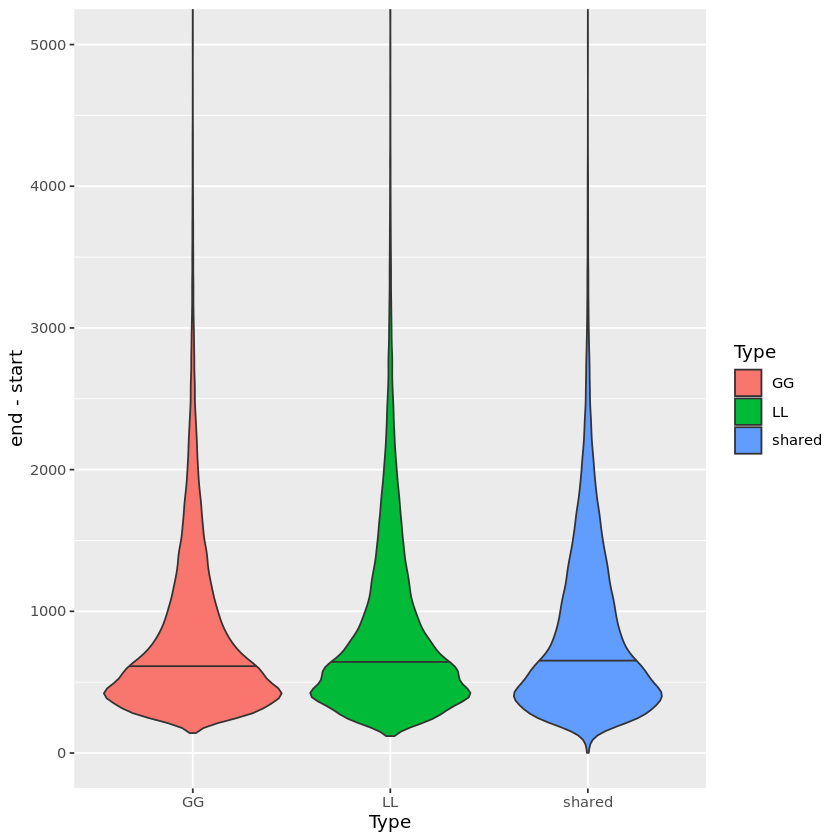

In [8]:
ggplot(df, aes(y=end-start, x=Type, fill =Type)) +
    geom_violin(draw_quantiles = c(0.5)) +
    coord_cartesian(ylim = c(0,5000))

In [1]:
%%bash
#obtain map-filtered bins that overlap this shared file. Set -u to write the original bins and preserve bin_ID. 
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong
bedtools intersect -u -a filtered_bins/50bp-tiling-bins.map-filt.hg38.bed \
    -b /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect.bed > \
    filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed

#confirm bin_ID is preserved in output
head filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed

chr1	941182	941232	bin_1012
chr1	941192	941242	bin_1013
chr1	941202	941252	bin_1014
chr1	941212	941262	bin_1015
chr1	941222	941272	bin_1016
chr1	941232	941282	bin_1017
chr1	941242	941292	bin_1018
chr1	941252	941302	bin_1019
chr1	941262	941312	bin_1020
chr1	941272	941322	bin_1021


In [2]:
%%bash
#how many bins?
wc -l /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed

2028304 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed


In [3]:
%%bash
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/filtered_bins
#how well do they match the other method?
bedtools intersect -f 0.99 -a 50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed \
    -b 50bp-tiling-bins.map-filt.shared.hg38.bed | wc -l 

1984354


__Summary__ 

The "by intersect" method just feels right. I will use that in the activity analysis. 

In [9]:
%%bash 
#Try sarah's union intersect method:
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks # go to directory

# take union of datasets. I.e. combine all regions in one file. filter for unique regions only
cat GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak \
LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak \
GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak \
LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak | uniq | \
bedtools intersect -a - -b GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak | \
bedtools intersect -a - -b LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak | \
bedtools intersect -a - -b GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak | \
bedtools intersect -a - -b LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak > \
shared_peaks_by-intersect_union.bed  # do sequential intersections against union file. 

In [10]:
%%bash
#how many peaks?
wc -l /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect_union.bed

120760 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect_union.bed


In [11]:
%%bash
#obtain map-filtered bins that overlap this shared file. Set -u to write the original bins and preserve bin_ID. 
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong
bedtools intersect -u -a filtered_bins/50bp-tiling-bins.map-filt.hg38.bed \
    -b /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks_by-intersect_union.bed | wc -l

2028304


Sarah's method gave the same number of bins!

### Extract and process species-biased bins

We want to study bins that are differentially accessible between the two cellular contexts. Since we used a simple bedtools intersect to get shared accessible bins I am going to extract species-specific bins in the following way:

1. Human-specific bins must be "accessible" in both GG and GL meaning they overlap called peaks in both contexts.
2. Bins that match this criteria will then be anti-joined with the shared bins by Bin_ID so that only bins that are not contained in the shared set are analyzed.

Vice-versa for rhesus and LL/LG.

In [1]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/3_noXY-filtered_peaks'
BINS='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/2_mappability-filtered_bins'
OUT='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output'

bedtools intersect -u -a ${BINS}/50bp-tiling-bins.map-filt-2bp.hg38.bed \
    -b ${DIR}/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak | \
    bedtools intersect -u -a - -b ${DIR}/GM12878inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak > \
    ${OUT}/GM12878-accessible_bins.bed

In [1]:
library(tidyverse)

dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/"

shared <- read_tsv(paste0(dir,"3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed"), 
                         col_names = c("chr", "start", "end", "Bin_ID"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Bin_ID = col_character()
)




In [2]:
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output"

G_acc <- read_tsv(paste0(dir,"/GM12878-accessible_bins.bed"), 
                         col_names = c("chr", "start", "end", "Bin_ID"))


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Bin_ID = col_character()
)




In [7]:
#anti_join
GG_specific <- anti_join(G_acc, shared, by="Bin_ID")

In [9]:
#Writeout
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins"
write_tsv(GG_specific, paste0(dir, "/50bp-tiling-bins.map-filt.human-specific_by-intersect.hg38.bed"),col_names = FALSE)

In [1]:
%%bash
#Rhesus specific
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/3_noXY-filtered_peaks'
BINS='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/2_mappability-filtered_bins'
OUT='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output'

bedtools intersect -u -a ${BINS}/50bp-tiling-bins.map-filt-2bp.hg38.bed \
    -b ${DIR}/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak | \
    bedtools intersect -u -a - -b ${DIR}/LCL8664inGM12878_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak > \
    ${OUT}/LCL8664-accessible_bins.bed

In [1]:
library(tidyverse)

dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/"

shared <- read_tsv(paste0(dir,"3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed"), 
                         col_names = c("chr", "start", "end", "Bin_ID"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Bin_ID = col_character()
)




In [2]:
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output"

L_acc <- read_tsv(paste0(dir,"/LCL8664-accessible_bins.bed"), 
                         col_names = c("chr", "start", "end", "Bin_ID"))


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  Bin_ID = col_character()
)




In [4]:
#anti_join
LL_specific <- anti_join(L_acc, shared, by="Bin_ID")

In [5]:
#Writeout
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins"
write_tsv(LL_specific, paste0(dir, "/50bp-tiling-bins.map-filt.rhesus-specific_by-intersect.hg38.bed"),col_names = FALSE)

In [1]:
%%bash
#how many bins were parsed?
DATA="/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins"
wc -l ${DATA}/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed
wc -l ${DATA}/50bp-tiling-bins.map-filt.human-specific_by-intersect.hg38.bed
wc -l ${DATA}/50bp-tiling-bins.map-filt.rhesus-specific_by-intersect.hg38.bed

2028304 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed
1637474 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.human-specific_by-intersect.hg38.bed
1548583 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.rhesus-specific_by-intersect.hg38.bed


In [25]:
#what are the percentages?
sum <- 2028304 + 1637474 + 1548583
sum
2028304/sum
1637474/sum
1548583/sum

[1] 5214361

[1] 0.3889842

[1] 0.3140316

[1] 0.2969842

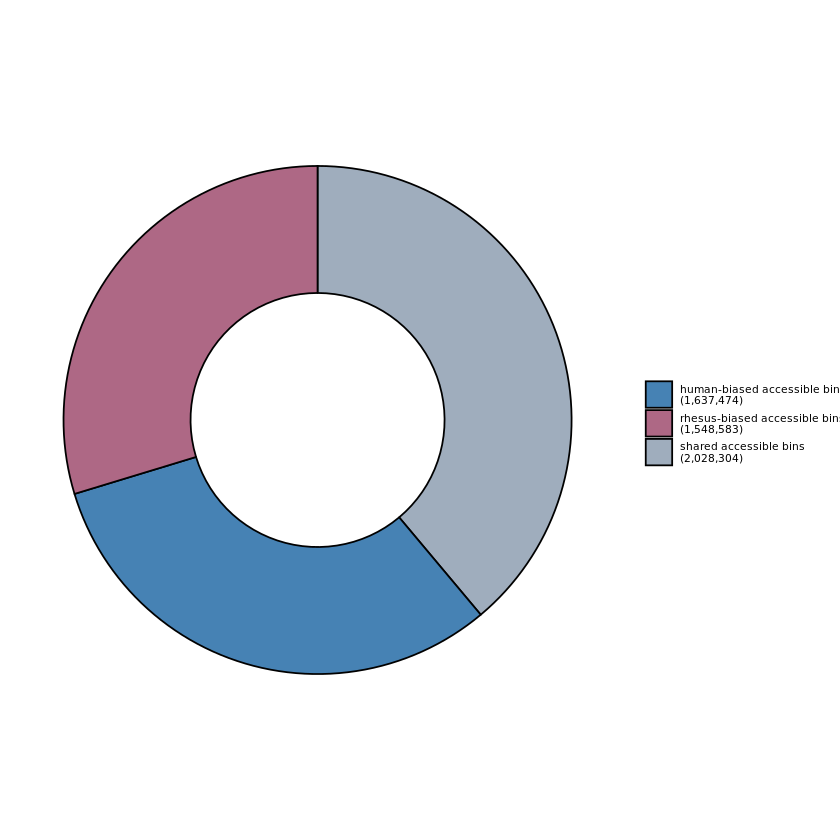

In [23]:
#plot donut of bins that are diff accessible
library(tidyverse)

plotDonut <- function(data){
    # Compute percentages
    data$fraction <- data$count / sum(data$count)
    # Compute the cumulative percentages (top of each rectangle)
    data$ymax <- cumsum(data$fraction)
    # Compute the bottom of each rectangle
    data$ymin <- c(0, head(data$ymax, n=-1))
    # Compute label position
    data$labelPosition <- (data$ymax + data$ymin) / 2
    # Compute a good label
    data$label <- paste0(data$category, "\n value: ", data$count)
    # Make the plot
    p <- ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=category)) +
      geom_rect(color = "black") +
      scale_fill_manual(values = c("#4682B4", "#AE6885", "#9FADBD")) +
      coord_polar(theta="y") +
      xlim(c(2, 4)) +
      theme_void(base_size = 8) +
      theme(legend.title = element_blank())
    return(p)
}

#build df
df <- data.frame(count = c(2028304, 1637474, 1548583), 
                category = c("shared accessible bins\n(2,028,304)", "human-biased accessible bins\n(1,637,474)",
                             "rhesus-biased accessible bins\n(1,548,583)"))

#Execute function.
p <- plotDonut(data = df)
p

In [24]:
res_dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/'
ggsave(p, filename = paste0(res_dir, "/diff-accessibility_bins_donut.pdf"), device = cairo_pdf, width = 3, height = 3)

In [2]:
%%bash
#merge into 5-count regions
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins'

bedtools merge -c 1 -o count -i ${DIR}/50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed | \
awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > ${DIR}/50bp-tiling-bins.map-filt.shared_by-intersect.merged.hg38.bed 

bedtools merge -c 1 -o count -i ${DIR}/50bp-tiling-bins.map-filt.human-specific_by-intersect.hg38.bed | \
awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > ${DIR}/50bp-tiling-bins.map-filt.human-specific_by-intersect.merged.hg38.bed 

bedtools merge -c 1 -o count -i ${DIR}/50bp-tiling-bins.map-filt.rhesus-specific_by-intersect.hg38.bed | \
awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > ${DIR}/50bp-tiling-bins.map-filt.rheus-specific_by-intersect.merged.hg38.bed 

In [4]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins'
#how many merged bins?
wc -l ${DIR}/50bp-tiling-bins.map-filt.shared_by-intersect.merged.hg38.bed 
wc -l ${DIR}/50bp-tiling-bins.map-filt.human-specific_by-intersect.merged.hg38.bed
wc -l ${DIR}/50bp-tiling-bins.map-filt.rheus-specific_by-intersect.merged.hg38.bed

86099 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.shared_by-intersect.merged.hg38.bed
84729 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.human-specific_by-intersect.merged.hg38.bed
78008 /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/50bp-tiling-bins.map-filt.rheus-specific_by-intersect.merged.hg38.bed


### Create CHRACC section in ini

In [ ]:
#function
append_section_to_ini <- function(ini_file, new_section) {
    if (is.list(new_section)) {
        ini <- ini::read.ini(ini_file)
        ini <- c(ini,new_section)
        ini::write.ini(x=ini, filepath=ini_file)
    } else {
        print('new_section is not a list')
    }
}

#list of key-value pairs
CHRACC <- list(ind_dir='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/3_noXY-filtered_peaks',
               shared_dir='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/shared_peaks', 
               hu_peaks_hg38='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/3_noXY-filtered_peaks/GM12878inGM12878_DNA_genrich.filtered_1.8.noXY.narrowPeak',
               ma_peaks_hg38='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/3_noXY-filtered_peaks/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.hg38-from-rheMac10.narrowPeak',
               ma_peaks_rhemac10='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/chrAcc_peaks/3_noXY-filtered_peaks/LCL8664inLCL8664_DNA_genrich.filtered_1.8.noXY.narrowPeak')

#list of section, resulting in list of list.
new_section <- list(CHRACC=CHRACC)

#write ini
append_section_to_ini("../config.ini", new_section)

## Regulatory Activity

To do this, follow the strategy employed in the NAR manuscript. In brief, this means assigning RNA and DNA readcounts to each bin with featureCounts then calling as active, or neutral/silent with DESeq2. Like the ChrAcc section above, we'll use the SAF files as input. 

### Make Counts

In [1]:
%%bash

#Generate counts for the orignial bin files and then intersct with the shared accessibility and map filterd bins later. 

BIN='/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/tyler'
DATA='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong'
BAM='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/individual_replicates'

#hg38
for i in GM12878inGM12878 GM12878inLCL8664
do
featureCounts -p -O -B --minOverlap 1 -T 12 -F SAF -a ${DATA}/tiling_bins/Hansen-Fong_50bp-tiling-bins_1.8.3reps.hg38.saf \
    -o ${DATA}/activity-score-intermediates/Hansen-Fong_50bp-tiling-bins_1.8.${i}.activity-counts.tsv \
    ${BAM}/${i}_DNA_Rep1.filtered.n-sorted.bam \
    ${BAM}/${i}_DNA_Rep2.filtered.n-sorted.bam \
    ${BAM}/${i}_DNA_Rep3.filtered.n-sorted.bam \
    ${BAM}/${i}_RNA_Rep1.filtered.n-sorted.bam \
    ${BAM}/${i}_RNA_Rep2.filtered.n-sorted.bam \
    ${BAM}/${i}_RNA_Rep3.filtered.n-sorted.bam 
done 

#rheMac10
for i in LCL8664inGM12878 LCL8664inLCL8664
do
featureCounts -p -O -B --minOverlap 1 -T 12 -F SAF -a ${DATA}/tiling_bins/Hansen-Fong_50bp-tiling-bins_1.8.3reps.rheMac10.saf \
    -o ${DATA}/activity-score-intermediates/Hansen-Fong_50bp-tiling-bins_1.8.${i}.activity-counts.tsv \
    ${BAM}/${i}_DNA_Rep1.filtered.n-sorted.bam \
    ${BAM}/${i}_DNA_Rep2.filtered.n-sorted.bam \
    ${BAM}/${i}_DNA_Rep3.filtered.n-sorted.bam \
    ${BAM}/${i}_RNA_Rep1.filtered.n-sorted.bam \
    ${BAM}/${i}_RNA_Rep2.filtered.n-sorted.bam \
    ${BAM}/${i}_RNA_Rep3.filtered.n-sorted.bam
done 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 6 BAM files                                      ||
||                           o GM12878inGM12878_DNA_Rep1.filtered.n-sorte ... ||
||                           o GM12878inGM12878_DNA_Rep2.filtered.n-sorte ... ||
||                           o GM12878inGM12878_DNA_Rep3.filtered.n-sorte ... ||
||                           o GM12878inGM12878_RNA_Rep1.filtered

### Intersect counts with filtered/shared bins

In [9]:
library(tidyverse)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/3_diff-acc-filtered_bins/'

#read in filtered and shared bins
filtered_bins <- read_tsv(paste0(dir,"50bp-tiling-bins.map-filt.shared_by-intersect.hg38.bed"), 
                         col_names = c("chr", "start", "end", "Bin_ID"))

Rows: 2028304 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chr, Bin_ID
dbl (2): start, end


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [2]:
#read in GG counts, inner_join with filtered bins, remove zero-count bints and convert to matrix. 
GG <- read_tsv(paste0(dir,"/activity-score-intermediates/Hansen-Fong_50bp-tiling-bins_1.8.GM12878inGM12878.activity-counts.tsv"),
               col_names = c("Bin_ID", "Chr", "Start", "End", "Strand", "Length", "DNA1", "DNA2", "DNA3", "RNA1", "RNA2", "RNA3"), 
               col_types = "cciiciiiiiii", skip = 2) %>% 
    inner_join(filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(-Chr, -Start, -End, -Strand, -Length, -chr, -start, -end) %>% 
    column_to_rownames(var = "Bin_ID") %>% 
    filter_if(is.numeric, all_vars((.) != 0)) %>%
    as.matrix()

In [3]:
#read in GL counts, inner_join with filtered bins, remove zero-count bints and convert to matrix. 
GL <- read_tsv(paste0(dir,"/activity-score-intermediates/Hansen-Fong_50bp-tiling-bins_1.8.GM12878inLCL8664.activity-counts.tsv"),
               col_names = c("Bin_ID", "Chr", "Start", "End", "Strand", "Length", "DNA1", "DNA2", "DNA3", "RNA1", "RNA2", "RNA3"), 
               col_types = "cciiciiiiiii", skip = 2) %>% 
    inner_join(filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(-Chr, -Start, -End, -Strand, -Length, -chr, -start, -end) %>% 
    column_to_rownames(var = "Bin_ID") %>% 
    filter_if(is.numeric, all_vars((.) != 0)) %>%
    as.matrix()

In [4]:
#read in LG counts, inner_join with filtered bins, remove zero-count bints and convert to matrix. 
LG <- read_tsv(paste0(dir,"/activity-score-intermediates/Hansen-Fong_50bp-tiling-bins_1.8.LCL8664inGM12878.activity-counts.tsv"),
               col_names = c("Bin_ID", "Chr", "Start", "End", "Strand", "Length", "DNA1", "DNA2", "DNA3", "RNA1", "RNA2", "RNA3"), 
               col_types = "cciiciiiiiii", skip = 2) %>% 
    inner_join(filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(-Chr, -Start, -End, -Strand, -Length, -chr, -start, -end) %>% 
    column_to_rownames(var = "Bin_ID") %>% 
    filter_if(is.numeric, all_vars((.) != 0)) %>%
    as.matrix()

In [5]:
#read in LL counts, inner_join with filtered bins, remove zero-count bints and convert to matrix. 
LL <- read_tsv(paste0(dir,"/activity-score-intermediates/Hansen-Fong_50bp-tiling-bins_1.8.LCL8664inLCL8664.activity-counts.tsv"),
               col_names = c("Bin_ID", "Chr", "Start", "End", "Strand", "Length", "DNA1", "DNA2", "DNA3", "RNA1", "RNA2", "RNA3"), 
               col_types = "cciiciiiiiii", skip = 2) %>% 
    inner_join(filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(-Chr, -Start, -End, -Strand, -Length, -chr, -start, -end) %>% 
    column_to_rownames(var = "Bin_ID") %>% 
    filter_if(is.numeric, all_vars((.) != 0)) %>%
    as.matrix()

In [6]:
#check bin count. They differ due to 0 value. 
nrow(GG)
nrow(GL)
nrow(LG)
nrow(LL)

[1] 1957485

[1] 2012836

[1] 2003742

[1] 2019529

### Score Bins for Activity with DESeq2

In [7]:
#prep for DESeq2
library(DESeq2)
library(BiocParallel)

register(MulticoreParam(12))

# Prepare dataframe of sample info
condition <- c("DNA", "DNA", "DNA", "RNA", "RNA", "RNA")
RNames <- c("DNA1", "DNA2", "DNA3", "RNA1", "RNA2", "RNA3")
coldata <- data.frame(row.names = RNames, condition)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply

In [8]:
##GG - DESeq

#Check that coldata matches cts. Output should read as "TRUE". 
print(all(rownames(coldata) == colnames(GG)))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = GG, colData = coldata, design = ~ condition)

#differential expression analysis. Use local fit.  
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(12))

#Extract results: RNA/DNA. 
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(12))

#save dds and res objects for extracting correlation and other all bin data. 
save(dds, file = paste0(dir, "/activity-score-intermediates/GG_dds.Rdata"))
save(res, file = paste0(dir, "/activity-score-intermediates/GG_res.Rdata"))

[1] TRUE


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 12 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 12 workers



In [9]:
## GG - assign padj and l2fc values to analyzed bins

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#add positional information using left_join with filtered_bins (is already 0-based coordinates) and format to 3+bed file. 
bed <- left_join(res_df, filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(chr, start, end, Bin_ID, log2FoldChange, padj)

#Write bed file.
write_tsv(bed, paste0(dir,"/scored_bins/GG_activity_1.8.hg38.bed"), col_names = FALSE)

In [10]:
##LL - DESeq

#Check that coldata matches cts. Output should read as "TRUE". 
print(all(rownames(coldata) == colnames(LL)))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = LL, colData = coldata, design = ~ condition)

#differential expression analysis. Use local fit.  
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(12))

#Extract results: RNA/DNA. 
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(12))

#save dds and res objects for extracting correlation and other all bin data. 
save(dds, file = paste0(dir, "/activity-score-intermediates/LL_dds.Rdata"))
save(res, file = paste0(dir, "/activity-score-intermediates/LL_res.Rdata"))

[1] TRUE


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 12 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 12 workers



In [11]:
## LL - assign padj and l2fc values to analyzed bins

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#add positional information using left_join with filtered_bins (is already 0-based coordinates) and format to 3+bed file. 
bed <- left_join(res_df, filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(chr, start, end, Bin_ID, log2FoldChange, padj)

#Write bed file.
write_tsv(bed, paste0(dir,"/scored_bins/LL_activity_1.8.hg38.bed"), col_names = FALSE)

In [12]:
##LG - DESeq

#Check that coldata matches cts. Output should read as "TRUE". 
print(all(rownames(coldata) == colnames(LG)))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = LG, colData = coldata, design = ~ condition)

#differential expression analysis. Use local fit.  
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(12))

#Extract results: RNA/DNA. 
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(12))

#save dds and res objects for extracting correlation and other all bin data. 
save(dds, file = paste0(dir, "/activity-score-intermediates/LG_dds.Rdata"))
save(res, file = paste0(dir, "/activity-score-intermediates/LG_res.Rdata"))

[1] TRUE


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 12 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 12 workers



In [13]:
## LG - assign padj and l2fc values to analyzed bins

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#add positional information using left_join with filtered_bins (is already 0-based coordinates) and format to 3+bed file. 
bed <- left_join(res_df, filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(chr, start, end, Bin_ID, log2FoldChange, padj)

#Write bed file.
write_tsv(bed, paste0(dir,"/scored_bins/LG_activity_1.8.hg38.bed"), col_names = FALSE)

In [14]:
##GL - DESeq

#Check that coldata matches cts. Output should read as "TRUE". 
print(all(rownames(coldata) == colnames(GL)))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = GL, colData = coldata, design = ~ condition)

#differential expression analysis. Use local fit.  
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(12))

#Extract results: RNA/DNA. 
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(12))

#save dds and res objects for extracting correlation and other all bin data. 
save(dds, file = paste0(dir, "/activity-score-intermediates/GL_dds.Rdata"))
save(res, file = paste0(dir, "/activity-score-intermediates/GL_res.Rdata"))

[1] TRUE


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 12 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 12 workers



In [15]:
## GL - assign padj and l2fc values to analyzed bins

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#add positional information using left_join with filtered_bins (is already 0-based coordinates) and format to 3+bed file. 
bed <- left_join(res_df, filtered_bins, by = "Bin_ID") %>% 
    dplyr::select(chr, start, end, Bin_ID, log2FoldChange, padj)

#Write bed file.
write_tsv(bed, paste0(dir,"/scored_bins/GL_activity_1.8.hg38.bed"), col_names = FALSE)

### Correlation between replicates

Do this using deeptools rather than with the method I did in the paper

In [14]:
%%bash
cat correlation_deeptools.slrm
sbatch correlation_deeptools.slrm

#!/bin/bash
#SBATCH --time=24:00:00
#SBATCH --mem=64G
#SBATCH --cpus-per-task=8
#SBATCH --mail-type=ALL
#SBATCH --mail-user=tyler.j.hansen@vanderbilt.edu

BAM_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/individual_replicates'
RES_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/replicate_correlation'

for i in GM12878inGM12878 GM12878inLCL8664 LCL8664inGM12878 LCL8664inLCL8664
do
	multiBamSummary bins -p 8 --bamfiles ${BAM_DIR}/${i}_DNA_Rep{1..3}.filtered.pos-sorted.bam -e -o ${RES_DIR}/${i}-DNA_correlation_1kb_bins.npz --binSize 1000

	multiBamSummary bins -p 8 --bamfiles ${BAM_DIR}/${i}_RNA_Rep{1..3}.filtered.pos-sorted.bam -e -o ${RES_DIR}/${i}-RNA_correlation_1kb_bins.npz --binSize 1000
done
Submitted batch job 36042761


In [11]:
%%bash
#plot DNA files vs each other for each sample
RES_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/replicate_correlation'

for i in GM12878inGM12878 GM12878inLCL8664 LCL8664inGM12878 LCL8664inLCL8664
do
    plotCorrelation -in ${RES_DIR}/${i}-DNA_correlation_1kb_bins.npz \
    --corMethod pearson --skipZeros \
    --plotTitle "${i}" \
    --whatToPlot scatterplot --plotFile ${RES_DIR}/${i}_DNA_PearsonCorr.pdf \
    --labels DNA1 DNA2 DNA3     
done


Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.

Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.

Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.

Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.


In [12]:
%%bash
#plot RNA files vs each other for each sample
RES_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/replicate_correlation'

for i in GM12878inGM12878 GM12878inLCL8664 LCL8664inGM12878 LCL8664inLCL8664
do
    plotCorrelation -in ${RES_DIR}/${i}-RNA_correlation_1kb_bins.npz \
    --corMethod pearson --skipZeros \
    --plotTitle "${i}" \
    --whatToPlot scatterplot --plotFile ${RES_DIR}/${i}_RNA_PearsonCorr.pdf \
    --labels RNA1 RNA2 RNA3     
done


Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.

Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.

Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.

Outliers were detected in the data. Consider using the --removeOutliers parameter to avoid a bias in the pearson correlation.


### Threshold bins by padj rank to get about 10,000 active regions in all 4 conditions

In [1]:
library(tidyverse)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output/activity_DESeq2_IO/'

#read in activity scored bins. 
GG <- read_tsv(paste0(dir,"GG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"))
GL <- read_tsv(paste0(dir,"GL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"))
LG <- read_tsv(paste0(dir,"LG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"))
LL <- read_tsv(paste0(dir,"LL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Rows: 1957485 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chr, Bin_ID
dbl (4): start, end, log2FoldChange, padj


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 2012836 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chr, Bin_ID
dbl (4): start, end, log2FoldChange, padj


ℹ Use `spec()` to retrieve the full 

In [2]:
GG_active <- filter(GG, log2FoldChange > 0) %>% slice_min(padj, n = 148200)
LG_active <- filter(LG, log2FoldChange > 0) %>% slice_min(padj, n = 146880)
GL_active <- filter(GL, log2FoldChange > 0) %>% slice_min(padj, n = 157210)
LL_active <- filter(LL, log2FoldChange > 0) %>% slice_min(padj, n = 158750)

In [3]:
#write inactive bins also
GG_inactive <- anti_join(GG, GG_active)
LG_inactive <- anti_join(LG, LG_active)
GL_inactive <- anti_join(GL, GL_active)
LL_inactive <- anti_join(LL, LL_active)

Joining, by = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj")

Joining, by = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj")

Joining, by = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj")

Joining, by = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj")



In [3]:
#verify this worked
nrow(GG_active)
nrow(LG_active)
nrow(GL_active)
nrow(LL_active)

[1] 148200

[1] 146880

[1] 157210

[1] 158750

In [4]:
#what are the padj values for each case?
max(GG_active$padj)
max(GL_active$padj)
max(LG_active$padj)
max(LL_active$padj)

[1] 0.08204612

[1] 0.06351824

[1] 0.1099555

[1] 0.02568942

In [5]:
#write out 
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions"

GG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GG_active.bins.bed"), col_names = FALSE)
GL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GL_active.bins.bed"), col_names = FALSE)
LG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LG_active.bins.bed"), col_names = FALSE)
LL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LL_active.bins.bed"), col_names = FALSE)

In [4]:
#write out 
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions"

GG_inactive %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GG_inactive.bins.bed"), col_names = FALSE)
GL_inactive %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GL_inactive.bins.bed"), col_names = FALSE)
LG_inactive %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LG_inactive.bins.bed"), col_names = FALSE)
LL_inactive %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LL_inactive.bins.bed"), col_names = FALSE)

In [1]:
#bash
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions

for i in *
do
    echo $i
    sort -k1,1 -k2,2n $i | bedtools merge -c 1 -o count -i - | awk '{OFS=FS="\t"}{if ($4>=5) print}' - | wc -l
done

GG_active.bins.bed
10006
GL_active.bins.bed
10009
LG_active.bins.bed
10004
LL_active.bins.bed
10001


In [1]:
#write:
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions

sort -k1,1 -k2,2n GG_active.bins.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GG_active.regions.bed
    
sort -k1,1 -k2,2n GL_active.bins.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GL_active.regions.bed
    
sort -k1,1 -k2,2n LG_active.bins.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LG_active.regions.bed
    
sort -k1,1 -k2,2n LL_active.bins.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LL_active.regions.bed

### Create ACTIVITY section to config

In [1]:
#function
append_section_to_ini <- function(ini_file, new_section) {
    if (is.list(new_section)) {
        ini <- ini::read.ini(ini_file)
        ini <- c(ini,new_section)
        ini::write.ini(x=ini, filepath=ini_file)
    } else {
        print('new_section is not a list')
    }
}

#list of key-value pairs
ACTIVITY <- list(dir='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/', 
               HH_active_regions='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/GG_active.regions.bed',
               HM_active_regions='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/GL_active.regions.bed',
               MH_active_regions='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/LG_active.regions.bed',
               MM_active_regions='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/LL_active.regions.bed', 
               HH_active_bins='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/GG_active.bins.bed',
               HM_active_bins='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/GL_active.bins.bed',
               MH_active_bins='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/LG_active.bins.bed',
               MM_active_bins='/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/LL_active.bins.bed')

#list of section, resulting in list of list.
new_section <- list(ACTIVITY=ACTIVITY)

#write ini
append_section_to_ini("../config.ini", new_section)

## Annotation of Active Regions

In [2]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(ChIPseeker))
suppressPackageStartupMessages(library(TxDb.Hsapiens.UCSC.hg38.knownGene))
ini <- ini::read.ini("../config.ini")

In [3]:
my_function <- function(peak) {
    ChIPseeker::annotatePeak(peak, tssRegion = c(-2000, 1000), 
                 TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene,
                 level = "gene",
                 assignGenomicAnnotation = TRUE,
                 addFlankGeneInfo = TRUE)
}

In [4]:
hh <- my_function(ini$ACTIVITY$hh_active_regions)
hm <- my_function(ini$ACTIVITY$hm_active_regions)
mh <- my_function(ini$ACTIVITY$mh_active_regions)
mm <- my_function(ini$ACTIVITY$mm_active_regions)

>> loading peak file...				 2022-07-13 10:27:05 AM 
>> preparing features information...		 2022-07-13 10:27:05 AM 


  1655 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



>> identifying nearest features...		 2022-07-13 10:27:08 AM 
>> calculating distance from peak to TSS...	 2022-07-13 10:27:08 AM 
>> assigning genomic annotation...		 2022-07-13 10:27:08 AM 
>> adding flank feature information from peaks...	 2022-07-13 10:27:46 AM 
>> assigning chromosome lengths			 2022-07-13 10:27:49 AM 
>> done...					 2022-07-13 10:27:49 AM 
>> loading peak file...				 2022-07-13 10:27:49 AM 
>> preparing features information...		 2022-07-13 10:27:49 AM 
>> identifying nearest features...		 2022-07-13 10:27:49 AM 
>> calculating distance from peak to TSS...	 2022-07-13 10:27:49 AM 
>> assigning genomic annotation...		 2022-07-13 10:27:49 AM 
>> adding flank feature information from peaks...	 2022-07-13 10:27:54 AM 
>> assigning chromosome lengths			 2022-07-13 10:27:57 AM 
>> done...					 2022-07-13 10:27:57 AM 
>> loading peak file...				 2022-07-13 10:27:57 AM 
>> preparing features information...		 2022-07-13 10:27:57 AM 
>> identifying nearest features...		 202

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



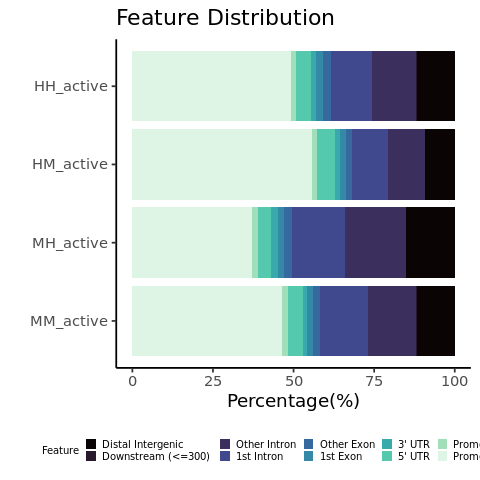

In [7]:
#annotation plots: 
addSmallLegend <- function(myPlot, pointSize = 3, textSize = 6, spaceLegend = 0.5) {
    myPlot +
        guides(shape = guide_legend(override.aes = list(size = pointSize)),
               color = guide_legend(override.aes = list(size = pointSize))) +
        theme(legend.title = element_text(size = textSize), 
              legend.text  = element_text(size = textSize),
              legend.key.size = unit(spaceLegend, "lines"))
}

p <- plotAnnoBar(list(HH_active = hh, HM_active = hm, MH_active = mh, MM_active = mm))

options(repr.plot.width = 4, repr.plot.height = 4)
p2 <- p + theme_classic() + theme(legend.position = "bottom") +  
    scale_fill_viridis_d(option = "mako") 
p3 <- addSmallLegend(p2)
p3
ggsave(plot = p3, filename = paste0(ini$ACTIVITY$plots, "/TSS-distribution.pdf"), device=cairo_pdf, height = 4, width = 4)

## Activity signal across replicates for +/- active bins

In [1]:
# HH
BINS_DIR=$(read-ini ../config.ini ACTIVITY dir)
R1=$(read-ini ../config.ini ACTIVITY_BW hh_r1)
R2=$(read-ini ../config.ini ACTIVITY_BW hh_r2)
R3=$(read-ini ../config.ini ACTIVITY_BW hh_r3)
PLOT_DIR=$(read-ini ../config.ini ACTIVITY plots)

#subsample inactive
shuf -n 150000 ${BINS_DIR}/GG_inactive.bins.bed > ${BINS_DIR}/GG_inactive.bins.sub.bed

computeMatrix reference-point -S $R1 $R2 $R3 \
    -R ${BINS_DIR}/GG_active.bins.bed ${BINS_DIR}/GG_inactive.bins.sub.bed \
    -a 500 -b 500 --referencePoint center --binSize 25 --missingDataAsZero -p 4 \
    -o ${PLOT_DIR}/matrix_HH_activity.gz
    
#plot heatmap from matricies.
plotHeatmap -m ${PLOT_DIR}/matrix_HH_activity.gz \
    -o ${PLOT_DIR}/heatmap_HH_activity.pdf \
    --dpi 300 --plotFileFormat pdf --sortRegions no \
    --refPointLabel center \
    --regionsLabel "active" "inactive" \
    --colorMap RdBu \
    --zMin -0.5 \
    --zMax 0.5 \
    --samplesLabel "Rep1" "Rep2" "Rep3" \
    --heatmapHeight 4.5 --heatmapWidth 1 --whatToShow 'heatmap and colorbar'

In [2]:
# MM
BINS_DIR=$(read-ini ../config.ini ACTIVITY dir)
R1=$(read-ini ../config.ini ACTIVITY_BW mm_r1)
R2=$(read-ini ../config.ini ACTIVITY_BW mm_r2)
R3=$(read-ini ../config.ini ACTIVITY_BW mm_r3)
PLOT_DIR=$(read-ini ../config.ini ACTIVITY plots)

#subsample inactive
shuf -n 150000 ${BINS_DIR}/LL_inactive.bins.bed > ${BINS_DIR}/LL_inactive.bins.sub.bed

computeMatrix reference-point -S $R1 $R2 $R3 \
    -R ${BINS_DIR}/LL_active.bins.bed ${BINS_DIR}/LL_inactive.bins.sub.bed \
    -a 500 -b 500 --referencePoint center --binSize 25 --missingDataAsZero -p 4 \
    -o ${PLOT_DIR}/matrix_LL_activity.gz
    
#plot heatmap from matricies.
plotHeatmap -m ${PLOT_DIR}/matrix_LL_activity.gz \
    -o ${PLOT_DIR}/heatmap_LL_activity.pdf \
    --dpi 300 --plotFileFormat pdf --sortRegions no \
    --refPointLabel center \
    --regionsLabel "active" "inactive" \
    --colorMap RdBu \
    --zMin -0.5 \
    --zMax 0.5 \
    --samplesLabel "Rep1" "Rep2" "Rep3" \
    --heatmapHeight 4.5 --heatmapWidth 1 --whatToShow 'heatmap and colorbar'

In [3]:
# MH
BINS_DIR=$(read-ini ../config.ini ACTIVITY dir)
R1=$(read-ini ../config.ini ACTIVITY_BW mh_r1)
R2=$(read-ini ../config.ini ACTIVITY_BW mh_r2)
R3=$(read-ini ../config.ini ACTIVITY_BW mh_r3)
PLOT_DIR=$(read-ini ../config.ini ACTIVITY plots)

#subsample inactive
shuf -n 150000 ${BINS_DIR}/LG_inactive.bins.bed > ${BINS_DIR}/LG_inactive.bins.sub.bed

computeMatrix reference-point -S $R1 $R2 $R3 \
    -R ${BINS_DIR}/LG_active.bins.bed ${BINS_DIR}/LG_inactive.bins.sub.bed \
    -a 500 -b 500 --referencePoint center --binSize 25 --missingDataAsZero -p 4 \
    -o ${PLOT_DIR}/matrix_LG_activity.gz
    
#plot heatmap from matricies.
plotHeatmap -m ${PLOT_DIR}/matrix_LG_activity.gz \
    -o ${PLOT_DIR}/heatmap_LG_activity.pdf \
    --dpi 300 --plotFileFormat pdf --sortRegions no \
    --refPointLabel center \
    --regionsLabel "active" "inactive" \
    --colorMap RdBu \
    --zMin -0.5 \
    --zMax 0.5 \
    --samplesLabel "Rep1" "Rep2" "Rep3" \
    --heatmapHeight 4.5 --heatmapWidth 1 --whatToShow 'heatmap and colorbar'

In [4]:
# HM
BINS_DIR=$(read-ini ../config.ini ACTIVITY dir)
R1=$(read-ini ../config.ini ACTIVITY_BW hm_r1)
R2=$(read-ini ../config.ini ACTIVITY_BW hm_r2)
R3=$(read-ini ../config.ini ACTIVITY_BW hm_r3)
PLOT_DIR=$(read-ini ../config.ini ACTIVITY plots)

#subsample inactive
shuf -n 150000 ${BINS_DIR}/GL_inactive.bins.bed > ${BINS_DIR}/GL_inactive.bins.sub.bed

computeMatrix reference-point -S $R1 $R2 $R3 \
    -R ${BINS_DIR}/GL_active.bins.bed ${BINS_DIR}/GL_inactive.bins.sub.bed \
    -a 500 -b 500 --referencePoint center --binSize 25 --missingDataAsZero -p 4 \
    -o ${PLOT_DIR}/matrix_GL_activity.gz
    
#plot heatmap from matricies.
plotHeatmap -m ${PLOT_DIR}/matrix_GL_activity.gz \
    -o ${PLOT_DIR}/heatmap_GL_activity.pdf \
    --dpi 300 --plotFileFormat pdf --sortRegions no \
    --refPointLabel center \
    --regionsLabel "active" "inactive" \
    --colorMap RdBu \
    --zMin -0.5 \
    --zMax 0.5 \
    --samplesLabel "Rep1" "Rep2" "Rep3" \
    --heatmapHeight 4.5 --heatmapWidth 1 --whatToShow 'heatmap and colorbar'

 ## Bar Chart of Counts

In [15]:
ini <- ini::read.ini("../config.ini")

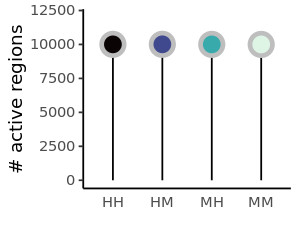

In [18]:
#r kernel
options(repr.plot.width = 2.5, repr.plot.height = 2)

df <- data.frame(condition = c("HH", "HM", "MH", "MM"), 
    value = c(10006, 10009, 10004, 10001))

library(tidyverse)

p <- ggplot(df, aes(x = condition, y = value, fill = condition)) +
  geom_segment(aes(x = condition, xend = condition, y = 0, yend = value), color = "black") +
  geom_point(size=5, alpha=1, shape=21, stroke=2, color = "grey") +
  scale_fill_viridis_d(option = "mako") +
  theme_classic() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "none"
  ) +
  xlab("") +
  ylab("# active regions") +
  coord_cartesian(ylim = c(0, 12000))
p

ggsave(plot = p, filename = paste0(ini$ACTIVITY$plots, "/active_region_counts.pdf"), device = cairo_pdf, width = 2.5, height = 2)

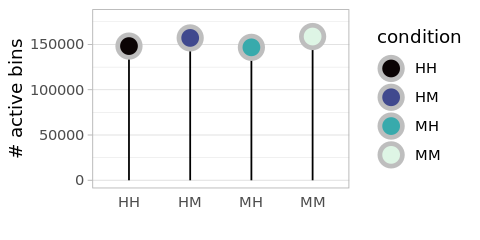

In [24]:
#r kernel
options(repr.plot.width = 4, repr.plot.height = 2)

df <- data.frame(condition = c("HH", "HM", "MH", "MM"), 
    value = c(148200, 157210, 146800, 158750))

library(tidyverse)

ggplot(df, aes(x = condition, y = value, fill = condition)) +
  geom_segment(aes(x = condition, xend = condition, y = 0, yend = value), color = "black") +
  geom_point(size=5, alpha=1, shape=21, stroke=2, color = "grey") +
  scale_fill_viridis_d(option = "mako") +
  theme_light() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  xlab("") +
  ylab("# active bins") +
  coord_cartesian(ylim = c(0, 180000))

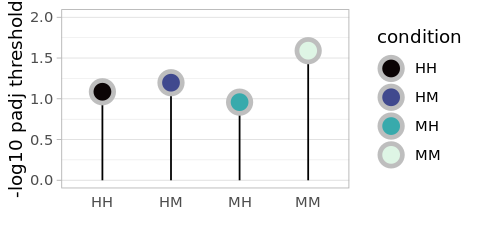

In [29]:
#r kernel
options(repr.plot.width = 4, repr.plot.height = 2)

df <- data.frame(condition = c("HH", "HM", "MH", "MM"), 
    value = c(0.0820, 0.0635, 0.110, 0.0257))

library(tidyverse)

ggplot(df, aes(x = condition, y = -log10(value), fill = condition)) +
  geom_segment(aes(x = condition, xend = condition, y = 0, yend = -log10(value)), color = "black") +
  geom_point(size=5, alpha=1, shape=21, stroke=2, color = "grey") +
  scale_fill_viridis_d(option = "mako") +
  theme_light() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  xlab("") +
  ylab("-log10 padj threshold") +
  coord_cartesian(ylim = c(0, 2))

## Complexity barchart

In [1]:
ini <- ini::read.ini("../config.ini")
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



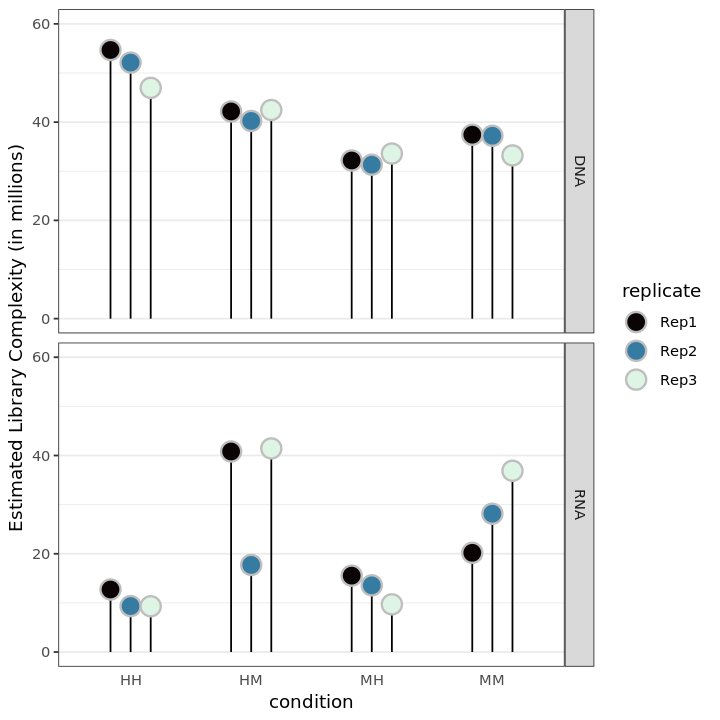

In [36]:
#r kernel
options(repr.plot.width = 6, repr.plot.height = 6)

#from picard
df <- data.frame(condition = c("HH", "HM", "MH", "MM","HH", "HM", "MH", "MM","HH", "HM", "MH", "MM",
                               "HH", "HM", "MH", "MM","HH", "HM", "MH", "MM","HH", "HM", "MH", "MM"),
                 replicate = c("Rep1", "Rep1", "Rep1", "Rep1","Rep2", "Rep2", "Rep2", "Rep2","Rep3", "Rep3", "Rep3", "Rep3",
                               "Rep1", "Rep1", "Rep1", "Rep1","Rep2", "Rep2", "Rep2", "Rep2","Rep3", "Rep3", "Rep3", "Rep3"),
                 type = c("DNA", "DNA", "DNA", "DNA", "DNA", "DNA", "DNA", "DNA", "DNA", "DNA", "DNA", "DNA",
                          "RNA", "RNA", "RNA", "RNA", "RNA", "RNA", "RNA", "RNA", "RNA", "RNA", "RNA", "RNA"),
                 complexity = c(54680528, 42170654, 32190943, 37439747, 
                                52116814, 40239996, 31334721, 37225215, 
                                46975957, 42466812, 33607308, 33227805, 
                                12724596, 40815821, 15541262, 20193934, 
                                9344860, 17723397, 13567216, 28147891, 
                                9310556, 41440883, 9704257, 36893121))

library(tidyverse)

p <- ggplot(df, aes(x = condition, y = complexity/1e6, fill = replicate)) +
  #geom_segment(aes(x = condition, xend = condition, y = 0, yend = complexity), color = "black", position = position_dodge(width = 1)) +
  geom_linerange(aes(xmin = condition, xmax = condition, ymin = 0, ymax = complexity/1e6), color = "black", position = position_dodge(width = 0.5)) +
  geom_point(size=5, alpha=1, shape=21, stroke=1, color = "grey", position = position_dodge(width = 0.5)) +
  facet_grid(type~., ) +
  scale_fill_viridis_d(option = "mako") +
  theme_bw() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  ylab("Estimated Library Complexity (in millions)") +
  coord_cartesian(ylim = c(0, 60))

p

ggsave(p, filename = paste0(ini$ACTIVITY$plots, "/complexity_lollipop.pdf"), device = cairo_pdf, width = 6, height = 6)

## Threshold effect on cis/trans differential activity

### Top 50K regions

In [1]:
library(tidyverse)
ini <- ini::read.ini("../config.ini")

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output/activity_DESeq2_IO/'

#read in activity scored bins. 
GG <- read_tsv(paste0(dir,"GG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
GL <- read_tsv(paste0(dir,"GL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
LG <- read_tsv(paste0(dir,"LG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
LL <- read_tsv(paste0(dir,"LL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
GG_active <- filter(GG, log2FoldChange > 0) %>% slice_min(padj, n = 860000)
GL_active <- filter(GL, log2FoldChange > 0) %>% slice_min(padj, n = 860000)
LG_active <- filter(LG, log2FoldChange > 0) %>% slice_min(padj, n = 880000)
LL_active <- filter(LL, log2FoldChange > 0) %>% slice_min(padj, n = 900000)

In [3]:
#what are the padj values for each case?
max(GG_active$padj)
max(GL_active$padj)
max(LG_active$padj)
max(LL_active$padj)

[1] 0.8275768

[1] 0.9198256

[1] 0.8634477

[1] 0.8149705

In [4]:
#write out 
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing"

GG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GG_active.bins.50k.bed"), col_names = FALSE)
GL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GL_active.bins.50k.bed"), col_names = FALSE)
LG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LG_active.bins.50k.bed"), col_names = FALSE)
LL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LL_active.bins.50k.bed"), col_names = FALSE)

In [2]:
#bash
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

for i in *50k.bed
do
    echo $i
    sort -k1,1 -k2,2n $i | bedtools merge -c 1 -o count -i - | awk '{OFS=FS="\t"}{if ($4>=5) print}' - | wc -l
done

GG_active.bins.50k.bed
50788
GL_active.bins.50k.bed
49345
LG_active.bins.50k.bed
51388
LL_active.bins.50k.bed
50895


In [3]:
#write:
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

sort -k1,1 -k2,2n GG_active.bins.50k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GG_active.regions.50k.bed
    
sort -k1,1 -k2,2n GL_active.bins.50k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GL_active.regions.50k.bed
    
sort -k1,1 -k2,2n LG_active.bins.50k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LG_active.regions.50k.bed
    
sort -k1,1 -k2,2n LL_active.bins.50k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LL_active.regions.50k.bed

### Top 25K regions

In [1]:
library(tidyverse)
ini <- ini::read.ini("../config.ini")

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output/activity_DESeq2_IO/'

#read in activity scored bins. 
GG <- read_tsv(paste0(dir,"GG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
GL <- read_tsv(paste0(dir,"GL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
LG <- read_tsv(paste0(dir,"LG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
LL <- read_tsv(paste0(dir,"LL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



In [2]:
GG_active <- filter(GG, log2FoldChange > 0) %>% slice_min(padj, n = 400000)
GL_active <- filter(GL, log2FoldChange > 0) %>% slice_min(padj, n = 400000)
LG_active <- filter(LG, log2FoldChange > 0) %>% slice_min(padj, n = 400000)
LL_active <- filter(LL, log2FoldChange > 0) %>% slice_min(padj, n = 400000)

In [3]:
#what are the padj values for each case?
max(GG_active$padj)
max(GL_active$padj)
max(LG_active$padj)
max(LL_active$padj)

[1] 0.3632454

[1] 0.3703131

[1] 0.4150486

[1] 0.2013587

In [4]:
#write out 
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing"

GG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GG_active.bins.25k.bed"), col_names = FALSE)
GL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GL_active.bins.25k.bed"), col_names = FALSE)
LG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LG_active.bins.25k.bed"), col_names = FALSE)
LL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LL_active.bins.25k.bed"), col_names = FALSE)

In [1]:
#bash
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

for i in *25k.bed
do
    echo $i
    sort -k1,1 -k2,2n $i | bedtools merge -c 1 -o count -i - | awk '{OFS=FS="\t"}{if ($4>=5) print}' - | wc -l
done

GG_active.bins.25k.bed
25876
GL_active.bins.25k.bed
24822
LG_active.bins.25k.bed
25765
LL_active.bins.25k.bed
24624


In [2]:
#write:
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

sort -k1,1 -k2,2n GG_active.bins.25k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GG_active.regions.25k.bed
    
sort -k1,1 -k2,2n GL_active.bins.25k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GL_active.regions.25k.bed
    
sort -k1,1 -k2,2n LG_active.bins.25k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LG_active.regions.25k.bed
    
sort -k1,1 -k2,2n LL_active.bins.25k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LL_active.regions.25k.bed

### Top 5K regions

In [1]:
library(tidyverse)
ini <- ini::read.ini("../config.ini")

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/bin-analysis_input+output/activity_DESeq2_IO/'

#read in activity scored bins. 
GG <- read_tsv(paste0(dir,"GG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
GL <- read_tsv(paste0(dir,"GL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
LG <- read_tsv(paste0(dir,"LG_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)
LL <- read_tsv(paste0(dir,"LL_activity_1.8.hg38.bed"), col_names = c("chr", "start", "end", "Bin_ID", "log2FoldChange", "padj"), show_col_types = FALSE)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



In [2]:
GG_active <- filter(GG, log2FoldChange > 0) %>% slice_min(padj, n = 74000)
GL_active <- filter(GL, log2FoldChange > 0) %>% slice_min(padj, n = 79000)
LG_active <- filter(LG, log2FoldChange > 0) %>% slice_min(padj, n = 71000)
LL_active <- filter(LL, log2FoldChange > 0) %>% slice_min(padj, n = 79000)

In [3]:
#what are the padj values for each case?
max(GG_active$padj)
max(GL_active$padj)
max(LG_active$padj)
max(LL_active$padj)

[1] 0.02007342

[1] 0.007345049

[1] 0.0304141

[1] 0.003090352

In [4]:
#write out 
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing"

GG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GG_active.bins.5k.bed"), col_names = FALSE)
GL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/GL_active.bins.5k.bed"), col_names = FALSE)
LG_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LG_active.bins.5k.bed"), col_names = FALSE)
LL_active %>% select(chr, start, end) %>% write_tsv(paste0(dir, "/LL_active.bins.5k.bed"), col_names = FALSE)

In [1]:
#bash
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

for i in *.5k.bed
do
    echo $i
    sort -k1,1 -k2,2n $i | bedtools merge -c 1 -o count -i - | awk '{OFS=FS="\t"}{if ($4>=5) print}' - | wc -l
done

GG_active.bins.5k.bed
4988
GL_active.bins.5k.bed
5078
LG_active.bins.5k.bed
4981
LL_active.bins.5k.bed
5039


In [2]:
#write:
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

sort -k1,1 -k2,2n GG_active.bins.5k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GG_active.regions.5k.bed
    
sort -k1,1 -k2,2n GL_active.bins.5k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > GL_active.regions.5k.bed
    
sort -k1,1 -k2,2n LG_active.bins.5k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LG_active.regions.5k.bed
    
sort -k1,1 -k2,2n LL_active.bins.5k.bed | bedtools merge -c 1 -o count -i - | \
    awk '{OFS=FS="\t"}{if ($4>=5) print $1,$2,$3}' - > LL_active.regions.5k.bed

### Compare thresholds on cis and trans effects numbers

In [1]:
cd /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/ATAC-STARR_bins/4_activity-filtered_bins/top_10K_regions/threshold_testing

#HH vs MM

#Cons active count
bedtools intersect -u -f 0.5 -F 0.5 -e -a GG_active.regions.50k.bed -b LL_active.regions.50k.bed | wc -l 
bedtools intersect -u -f 0.5 -F 0.5 -e -a GG_active.regions.25k.bed -b LL_active.regions.25k.bed | wc -l 
bedtools intersect -u -f 0.5 -F 0.5 -e -a GG_active.regions.5k.bed -b LL_active.regions.5k.bed | wc -l 

#HH_specific count and write
bedtools intersect -v -f 0.5 -F 0.5 -e -a GG_active.regions.50k.bed -b LL_active.regions.50k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a GG_active.regions.25k.bed -b LL_active.regions.25k.bed | wc -l 
bedtools intersect -v -f 0.5 -F 0.5 -e -a GG_active.regions.5k.bed -b LL_active.regions.5k.bed | wc -l 

bedtools intersect -v -f 0.5 -F 0.5 -e -a GG_active.regions.50k.bed -b LL_active.regions.50k.bed > hh-specific.50k.bed
bedtools intersect -v -f 0.5 -F 0.5 -e -a GG_active.regions.25k.bed -b LL_active.regions.25k.bed > hh-specific.25k.bed
bedtools intersect -v -f 0.5 -F 0.5 -e -a GG_active.regions.5k.bed -b LL_active.regions.5k.bed > hh-specific.5k.bed 

#write MM regions that do not overlap
bedtools intersect -v -f 0.5 -F 0.5 -e -b GG_active.regions.50k.bed -a LL_active.regions.50k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -b GG_active.regions.25k.bed -a LL_active.regions.25k.bed | wc -l 
bedtools intersect -v -f 0.5 -F 0.5 -e -b GG_active.regions.5k.bed -a LL_active.regions.5k.bed | wc -l 

bedtools intersect -v -f 0.5 -F 0.5 -e -b GG_active.regions.50k.bed -a LL_active.regions.50k.bed > mm-specific.50k.bed
bedtools intersect -v -f 0.5 -F 0.5 -e -b GG_active.regions.25k.bed -a LL_active.regions.25k.bed > mm-specific.25k.bed
bedtools intersect -v -f 0.5 -F 0.5 -e -b GG_active.regions.5k.bed -a LL_active.regions.5k.bed > mm-specific.5k.bed 

34281
10995
1424
16507
14881
3564
17135
13771
3633


In [2]:
# Cis effects

bedtools intersect -v -f 0.5 -F 0.5 -e -a hh-specific.50k.bed -b LG_active.regions.50k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a hh-specific.25k.bed -b LG_active.regions.25k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a hh-specific.5k.bed -b LG_active.regions.5k.bed | wc -l

bedtools intersect -v -f 0.5 -F 0.5 -e -a mm-specific.50k.bed -b GL_active.regions.50k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a mm-specific.25k.bed -b GL_active.regions.25k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a mm-specific.5k.bed -b GL_active.regions.5k.bed | wc -l

8576
10695
3058
8863
8891
2569


In [3]:
# trans effects

bedtools intersect -v -f 0.5 -F 0.5 -e -a hh-specific.50k.bed -b GL_active.regions.50k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a hh-specific.25k.bed -b GL_active.regions.25k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a hh-specific.5k.bed -b GL_active.regions.5k.bed | wc -l

bedtools intersect -v -f 0.5 -F 0.5 -e -a mm-specific.50k.bed -b LG_active.regions.50k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a mm-specific.25k.bed -b LG_active.regions.25k.bed | wc -l
bedtools intersect -v -f 0.5 -F 0.5 -e -a mm-specific.5k.bed -b LG_active.regions.5k.bed | wc -l

9370
10613
2913
7347
8947
2782


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()



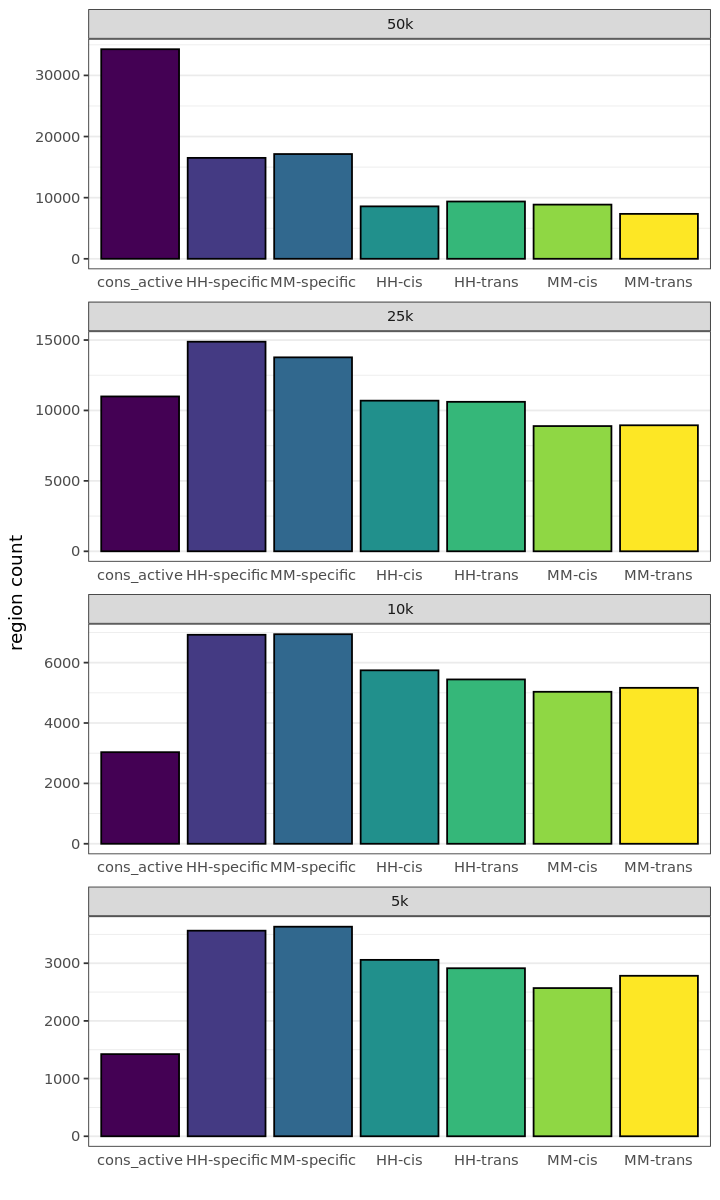

In [1]:
#r kernel
options(repr.plot.width = 6, repr.plot.height = 10)
ini <- ini::read.ini("../config.ini")
library(magrittr)
library(tidyverse)

#from picard
df <- data.frame(threshold = c("50k", "25k", "10k", "5k", 
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k"),
                 region_type = c("cons_active", "cons_active", "cons_active", "cons_active",
                                 "HH-specific", "HH-specific", "HH-specific", "HH-specific",
                                 "MM-specific", "MM-specific", "MM-specific", "MM-specific",
                                 "HH-cis", "HH-cis", "HH-cis", "HH-cis",
                                 "HH-trans", "HH-trans", "HH-trans", "HH-trans",
                                 "MM-cis", "MM-cis", "MM-cis", "MM-cis",
                                 "MM-trans", "MM-trans", "MM-trans", "MM-trans"),
                 region_count = c(34281, 10995, 3034, 1424,
                                  16507, 14881, 6922, 3564,
                                  17135, 13771, 6941, 3633,
                                  8576, 10695, 5745, 3058,
                                  9370, 10613, 5443, 2913,
                                  8863, 8891, 5034, 2569,
                                  7347, 8947, 5165, 2782))

df$threshold %<>% factor(levels = c("50k", "25k", "10k", "5k"))
df$region_type %<>% factor(levels = c("cons_active", "HH-specific", "MM-specific", "HH-cis", "HH-trans", "MM-cis", "MM-trans"))

p <- ggplot(df, aes(x = region_type, y = region_count, fill = region_type)) +
  geom_col(color = "black") +
  facet_wrap(~threshold, scales = "free", ncol = 1) +
  scale_fill_viridis_d(option = "viridis") +
  theme_bw() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.ticks.x = element_blank(), 
    legend.position = "none"
  ) +
  xlab("") +
  ylab("region count")

p

ggsave(p, filename = paste0(ini$ACTIVITY$plots, "/threshold_region_counts.pdf"), device = cairo_pdf, width = 6, height = 10)

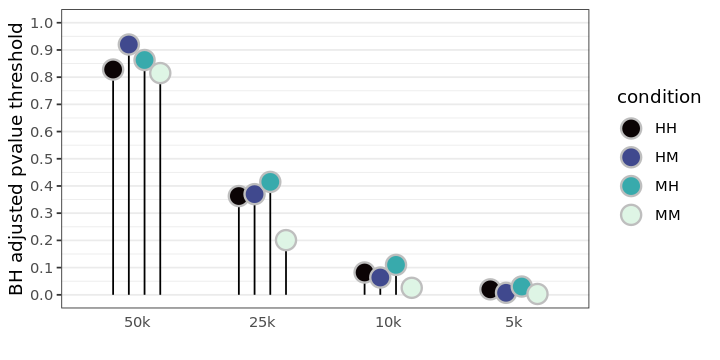

In [40]:
#r kernel
options(repr.plot.width = 6, repr.plot.height = 3)
ini <- ini::read.ini("../config.ini")
library(magrittr)
library(tidyverse)

#from picard
df <- data.frame(threshold = c("50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k",
                               "50k", "25k", "10k", "5k"),
                 condition = c("HH", "HH", "HH", "HH",
                               "HM", "HM", "HM", "HM",
                               "MH", "MH", "MH", "MH",
                               "MM", "MM", "MM", "MM"),
                 padj = c(0.828, 0.363, 0.0820, 0.0201,
                          0.920, 0.370, 0.0635, 0.00735,
                          0.863, 0.415, 0.110, 0.0304,
                          0.815, 0.201, 0.0257, 0.00309))

df$threshold %<>% factor(levels = c("50k", "25k", "10k", "5k"))

p <- ggplot(df, aes(x = threshold, y = padj, fill = condition)) +
  geom_linerange(aes(xmin = threshold, xmax = threshold, ymin = 0, ymax = padj), color = "black", position = position_dodge(width = 0.5)) +
  geom_point(size=5, alpha=1, shape=21, stroke=1, color = "grey", position = position_dodge(width = 0.5)) +
  scale_fill_viridis_d(option = "mako") +
  scale_y_continuous(breaks = seq(from = 0, to = 1, by = 0.1)) +
  theme_bw() +
  theme(
    panel.grid.major.x = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  ylab("BH adjusted pvalue threshold") +
  xlab("") +
  coord_cartesian(ylim = c(0, 1))

p

ggsave(p, filename = paste0(ini$ACTIVITY$plots, "/threshold_padj.pdf"), device = cairo_pdf, width = 6, height = 3)